In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from pandas.tseries.offsets import MonthEnd

import warnings
warnings.filterwarnings('ignore')

#### 1. Импортируем данные

In [229]:
df = pd.read_csv('accidental-deaths-in-usa-monthly.csv', 
                 sep=',')
df.rename(columns={'Accidental deaths in USA: monthly, 1973 ? 1978':'y',
                  'Month':'ds'}, inplace=True)
df.ds=pd.to_datetime(df.ds) + MonthEnd() #Поскольку количество смертей считается на последнюю дату месяца

#### 2. Построим график

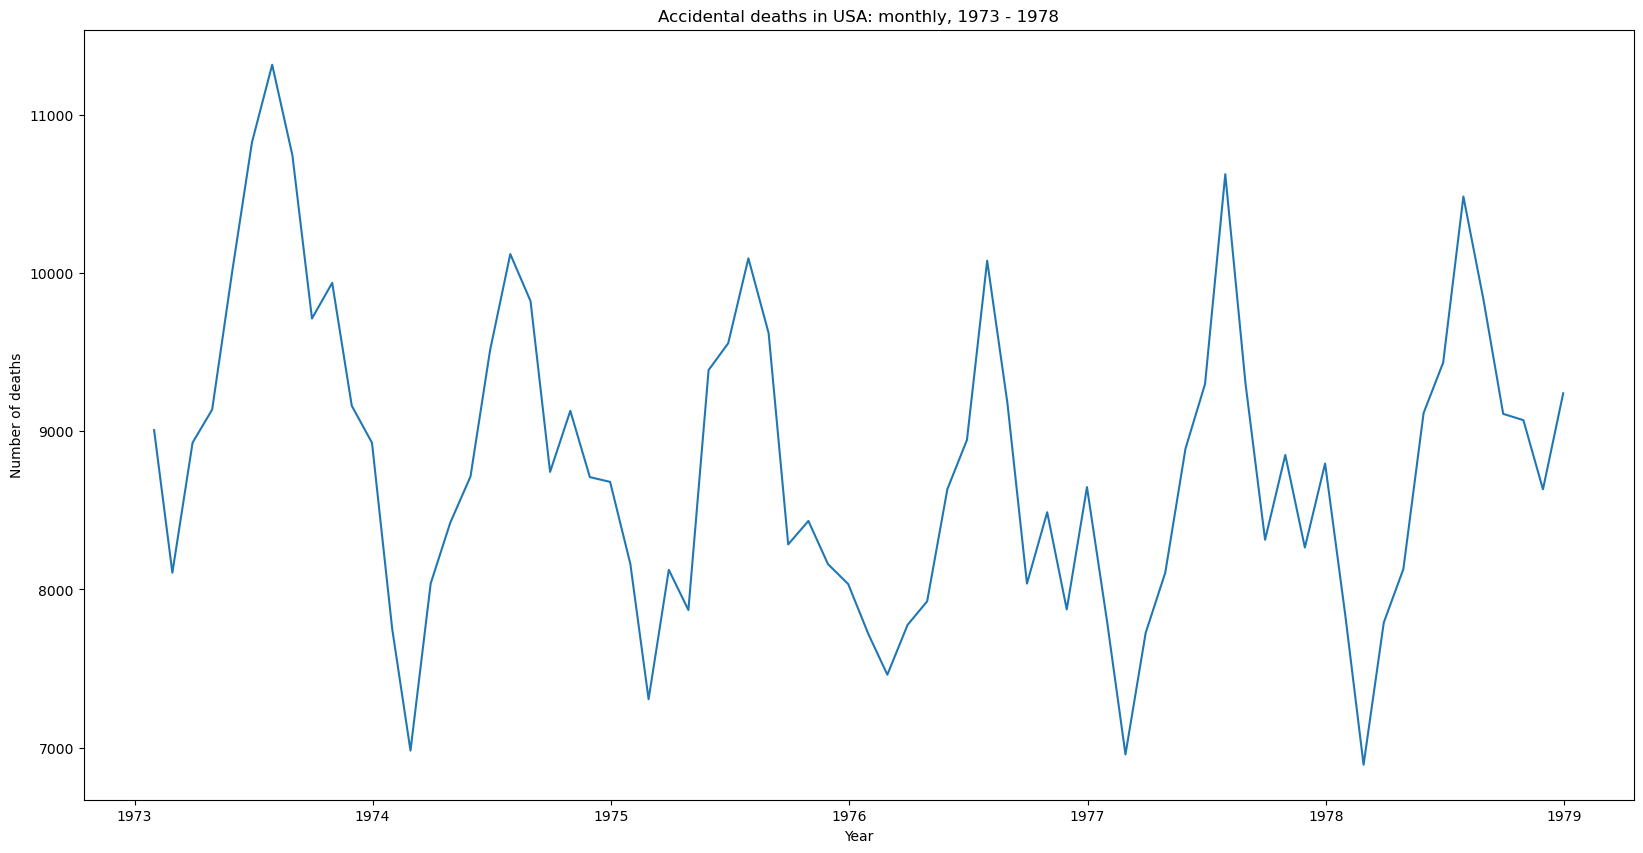

In [205]:
plt.figure (figsize=(20,10))
sns.lineplot(data=df, x='ds', y='y');
plt.title ('Accidental deaths in USA: monthly, 1973 - 1978');
plt.ylabel ('Number of deaths');
plt.xlabel ('Year');

#### 3. Оценим качество предсказаний на тестовом наборе на модели без гиперпараметров

In [278]:
predictions = 24

In [279]:
train_df = df[:-predictions]

In [280]:
m=Prophet()
m.fit (train_df)
future = m.make_future_dataframe(periods=predictions,freq='M')
forecast = m.predict(future)

00:19:33 - cmdstanpy - INFO - Chain [1] start processing
00:19:34 - cmdstanpy - INFO - Chain [1] done processing


In [281]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  8.90015356751375 %
MAE (средняя абсолютная ошибка) –  780.4559194858148


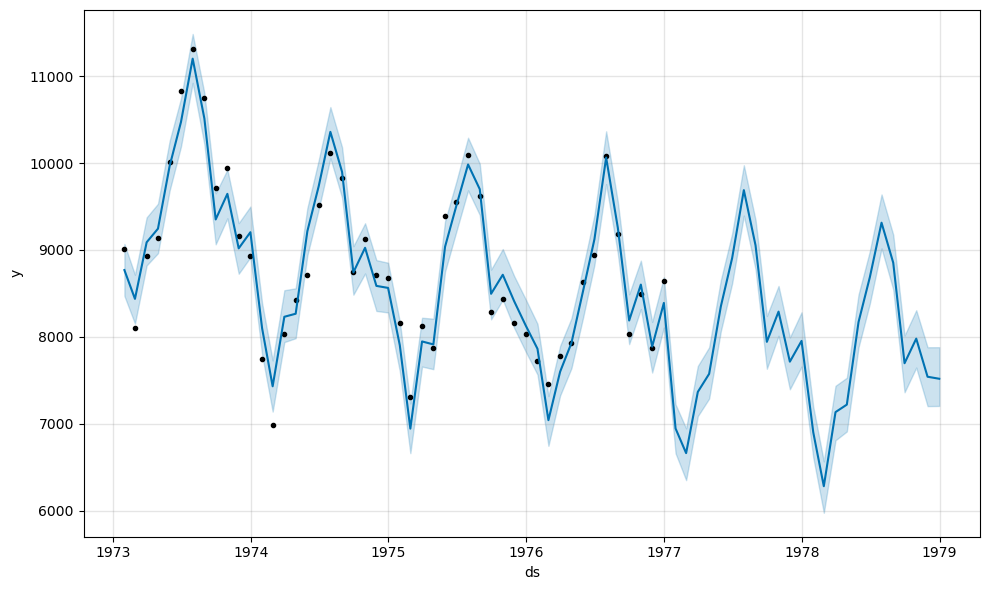

In [282]:
m.plot(forecast);

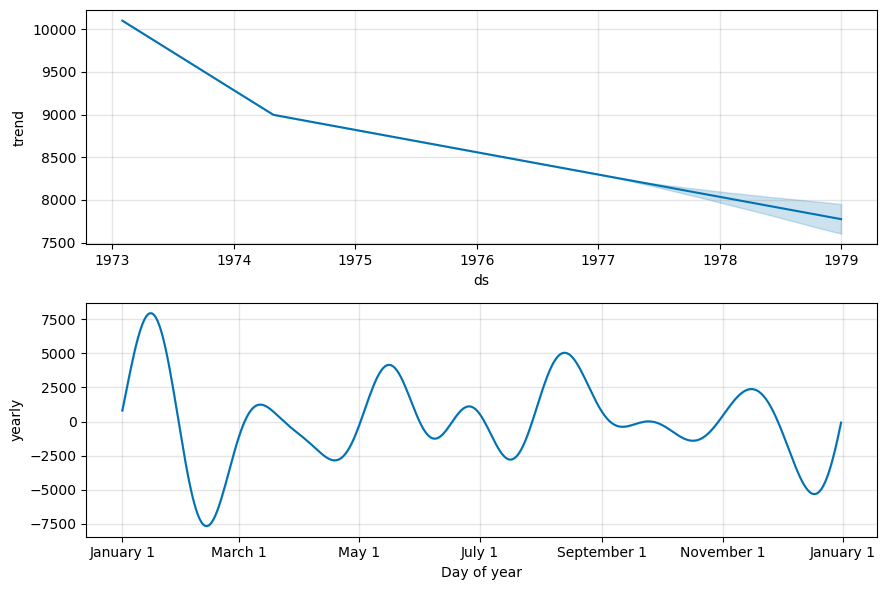

In [283]:
m.plot_components(forecast);

#### 4. Оценим качество предсказаний на тестовом наборе на модели с учетом праздничных дней

In [271]:
predictions = 24
train_df = df[:-predictions]

In [272]:
import holidays
holidays_dict = holidays.US(years=(1973,1974,1975, 1976, 1977, 1978, 1979,1980))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)

In [273]:
m = Prophet(holidays=df_holidays)
m.fit (train_df)

00:17:59 - cmdstanpy - INFO - Chain [1] start processing
00:18:00 - cmdstanpy - INFO - Chain [1] done processing


In [274]:
future = m.make_future_dataframe(periods=predictions,freq='M')
forecast = m.predict(future)

In [275]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  11.27264817227514 %
MAE (средняя абсолютная ошибка) –  986.7199564943779


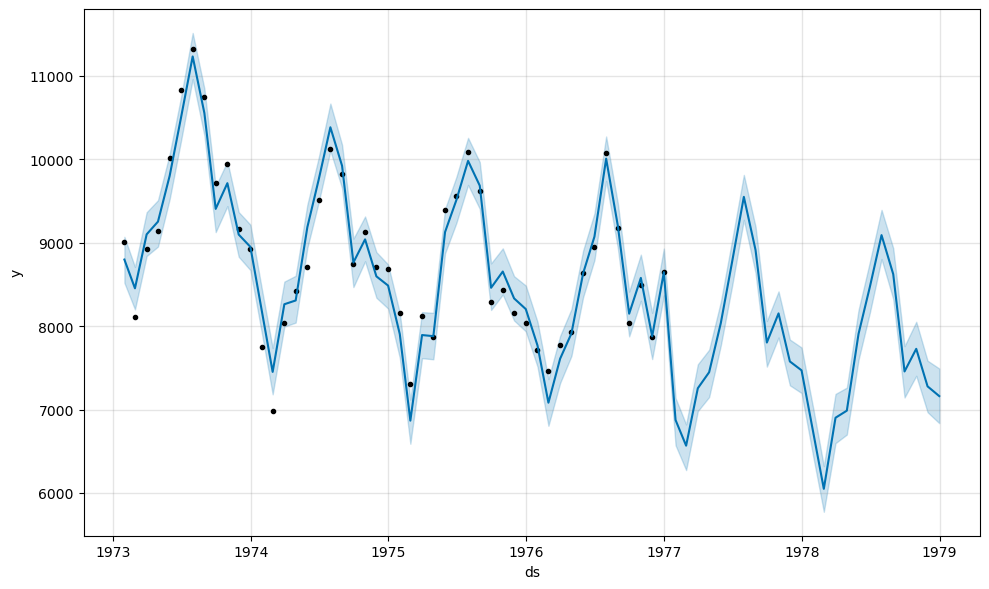

In [276]:
m.plot(forecast);

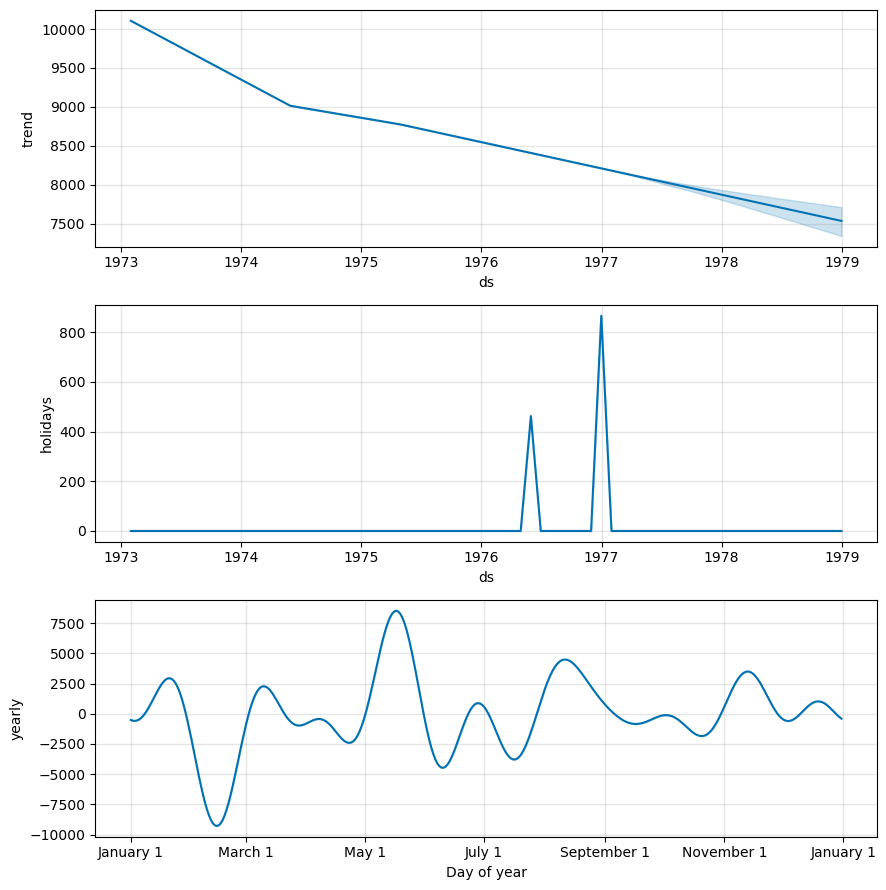

In [277]:
m.plot_components(forecast);

#### 4. Оценим качество предсказаний на тестовом наборе при включенных сезонностях

In [297]:
predictions = 24
train_df = df[:-predictions]

In [307]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit (train_df)

00:26:16 - cmdstanpy - INFO - Chain [1] start processing
00:26:17 - cmdstanpy - INFO - Chain [1] done processing


In [308]:
future = m.make_future_dataframe(periods=predictions,freq='M')
forecast = m.predict(future)

In [309]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  8.544479124740098 %
MAE (средняя абсолютная ошибка) –  753.3861616252376


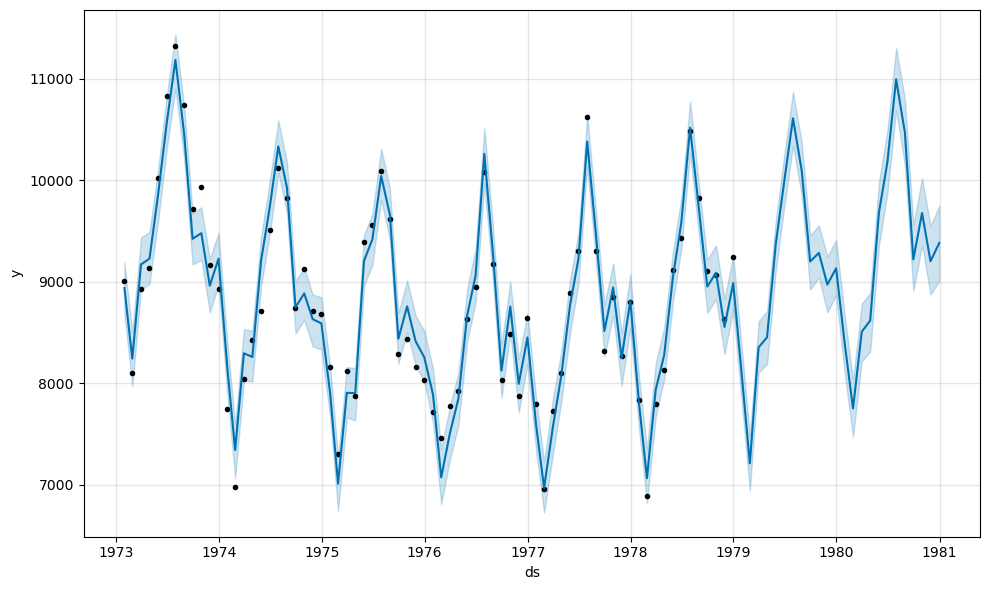

In [315]:
m.plot(forecast);

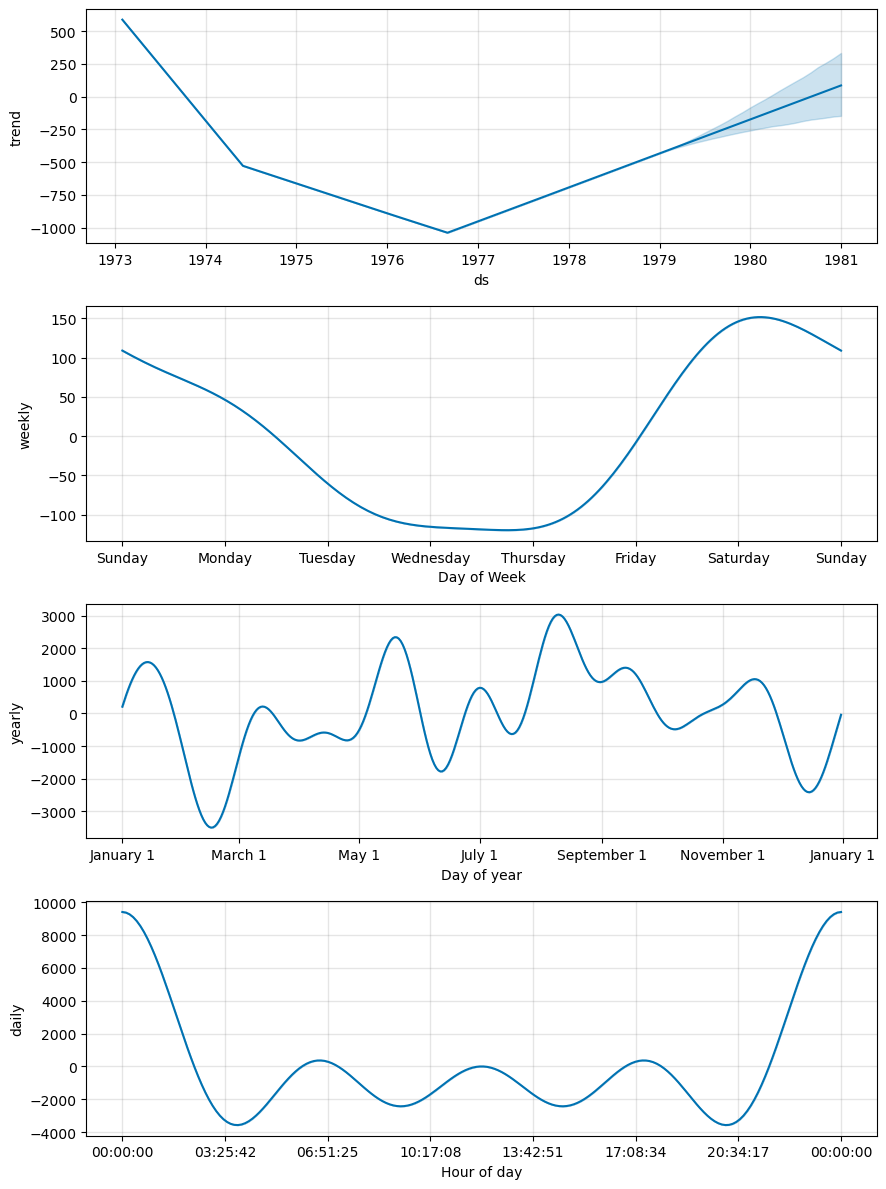

In [316]:
m.plot_components(forecast);

#### 5. Попробуем предсказать ряд на 2 года вперед

In [317]:
m=Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(df)

00:28:44 - cmdstanpy - INFO - Chain [1] start processing
00:28:46 - cmdstanpy - INFO - Chain [1] done processing


In [318]:
future = m.make_future_dataframe(periods=24,freq='M')

In [319]:
forecast = m.predict (future)

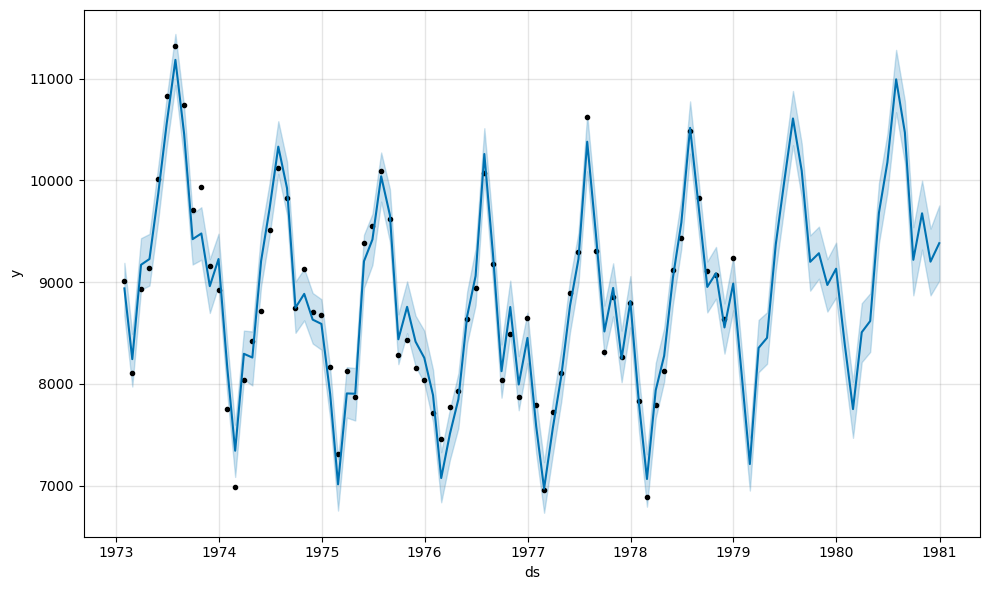

In [320]:
m.plot(forecast);

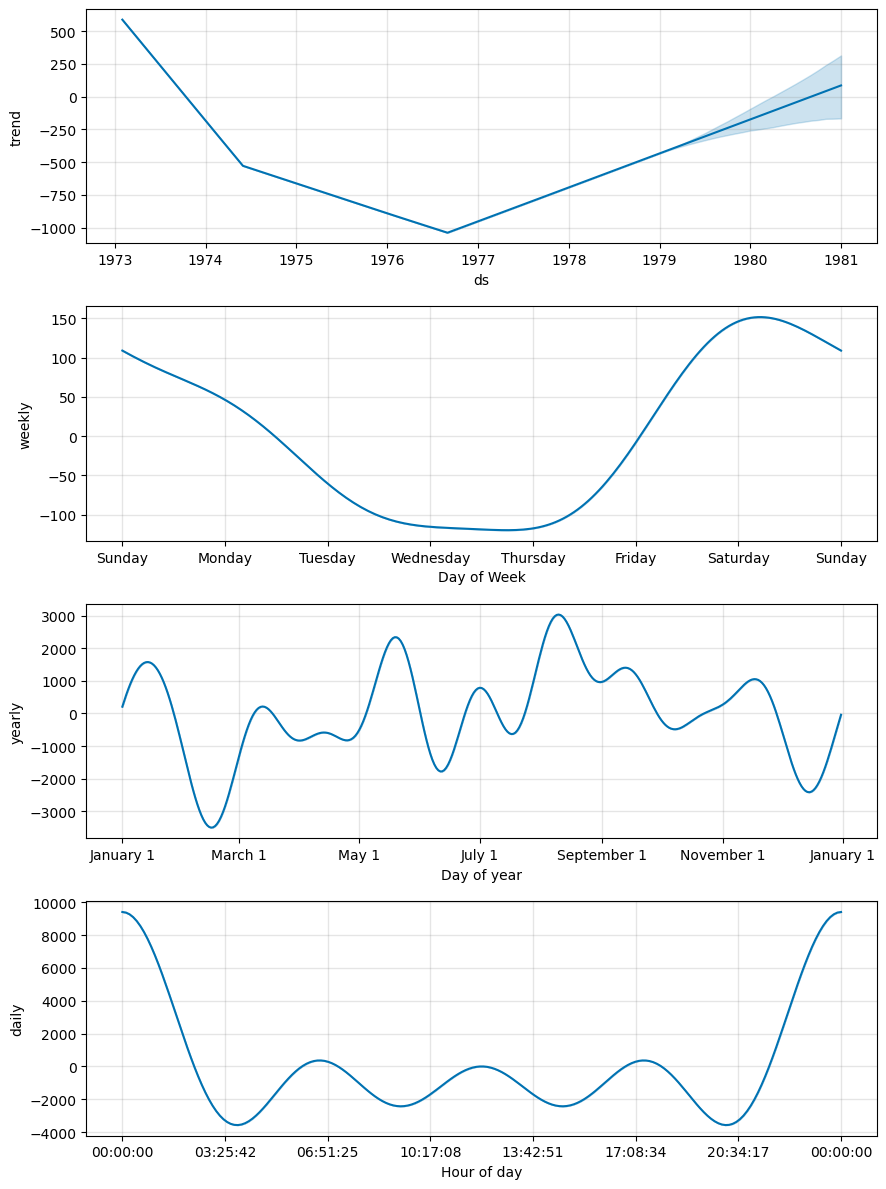

In [321]:
m.plot_components(forecast);

### Выводы:
1. Используемый временной ряд слишком мал для построения достоверных предсказаний
2. На тестовом наборе Prophet изначально без настройки показывает достаточно низкую ошибку (8.9%)
3. При добавлении информации о праздниках, предсказательная сила ухудшается и ошибка возрастает до 11.27%
4. Включение учета сезональностей снижает ошибку до 8.4% 
5. По результатам прогнозирования в следующие 2 года будет иметь место увеличение количетства смертей по сравнению с предыдущими годами.
6. Количество смертей имеет отчетливую годовую сезональность с максимумов в конце августа и минимумом в конце февраля